# Plotting with matplotlib

So far we've been using pretend data to practice plotting. 
Now let's try to plot something meaningful.
To complete these exercises you will need to use what you've learned about handling files, using pandas and plotting data with matplotlib. You will also likely need to search online for hints and use documentation to find appropriate solutions. 


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Exercise 1
The files 'annual_temperature.csv' and 'annual_sunshine_hours.csv' contain weather data from the [met office website](https://www.metoffice.gov.uk/research/climate/maps-and-data/uk-and-regional-series).
We will explore this data visually using matplotlib. 

### Part a
Plot the average annual temperature (column 'ann' in 'annual_temperature.csv') for each year in a line plot. 
On the same Axes, plot the five year rolling average temperature. 
That is, for each year, instead of plotting the annual temperature of that year only, plot the average temperature from that year and the past four. 
This is a way of smoothing the data to reduce noise and highlight trends.

Do the same for the average winter and summer temperature.
Create a figure with all three plots.
Add suitable labels and titles.

### Part b
Draw a bar chart showing the amount of sun in May (column 'may' in 'annual_sunshine_hours.csv') for every year and over this, sharing the same x axis, draw a line plot showing the temperature in May in each year.
The two plots each require a different y axis.
If you search online for how to do this you should soon find that the Axes method `twinx()` is needed. 
Look for examples and read the documentation to work out how to use it. 
Scale the y axis for the two plots so that the temperature line is close to the top of the bars. 
The aim is to get a visual impression of whether the temperature is higher in years when the amount of sun is greater. 
Notice that there are fewer sunshine than temperature records. 
Only plot the years in the range for which both data are available.

## Exercise 2
Now we will explore the data in the file 'life_expectancy_gdp_2011.csv'.
This data is taken from [Our World in Data](https://ourworldindata.org/grapher/life-expectancy-vs-gdp-per-capita?tab=chart&stackMode=absolute&country=&region=World) and we will aim to reproduce the plot shown there. 
Create a scatter plot. 
Set GDP to be the x axis and life expectancy on the y axis.
The x axis should use a log scale. 
The size of the data points should be proportional to the population of the country.

The colour of the points should indicate the continent that the country belongs to. 
This CSV file does not contain information about the continent, the file 'Continents.csv' does.
You'll need to match the data from the two files together using the country code column that is present in both. 
Remember that pandas provides methods to join two DataFrames together using a common column.

To further improve your plot:
- Create a legend which shows the continent that each color represents. This is challenging. You might find the [examples scatter plots with a legend](https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html) are helpful. 
- Annotate some of the data points with the name of the country using the Axes methos `annotate()` ([see documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.annotate.html?highlight=annotate#matplotlib.axes.Axes.annotate)). For example, you might annotate all countries with a population greater than 50 million.  

# Solutions to exercises

## Exercise 1 solution
### Part a solution
First import the data. 
The code here uses pandas but you could import using the CSV library instead.
There is one missing piece of data, it's a good idea to replace it with a pandas NA (or numpy NaN) at the beginning.

In [2]:
df = pd.read_csv('annual_temperatures.csv')

# fix the bad winter value in the first row
df.loc[0,'win'] = pd.NA
df['win'] = pd.to_numeric(df['win'],errors='coerce')

A function to calculate the rolling average for the annual, winter and summer temperatures.

In [3]:
def rolling_average(S, n):
    '''
    Calculate the rolling average of n items from S

            Parameters:
                S: A pandas series of numerical data
                n: An integer

            Returns:
                Pandas series of n item rolling average of S
    '''
    # list to collect averages
    # initialise to None for any that can't be calculated
    av = [None]*len(S)
        
    total = 0 # running total of last n items
    bad = 0 # keeps track of missing values
    
    for index, value in S.items(): 
        # can't do anything with missing values
        # can't calculate the next n averages (including this one)
        if pd.isna(value):
            bad = n-1
            continue
            
        total += value
        
        # to keep total up to date subtract value from 5 places earlier
        if index > 4: 
            old_val = S[index-5]
            # check the value to be subtracted is a number
            if pd.notna(old_val):
                total -= old_val 
        
        if bad:
            bad -= 1 # count down until ok to find average again
            continue # can't calculate this average
            
        if index > 3:
            av[index] = total/5 # calculate average and add to list
            
    return pd.Series(av) 

df['5_year_average'] = rolling_average(df['ann'], 5)
df['5_year_summer'] = rolling_average(df['sum'], 5)
df['5_year_winter'] = rolling_average(df['win'], 5)

Plotting the data.

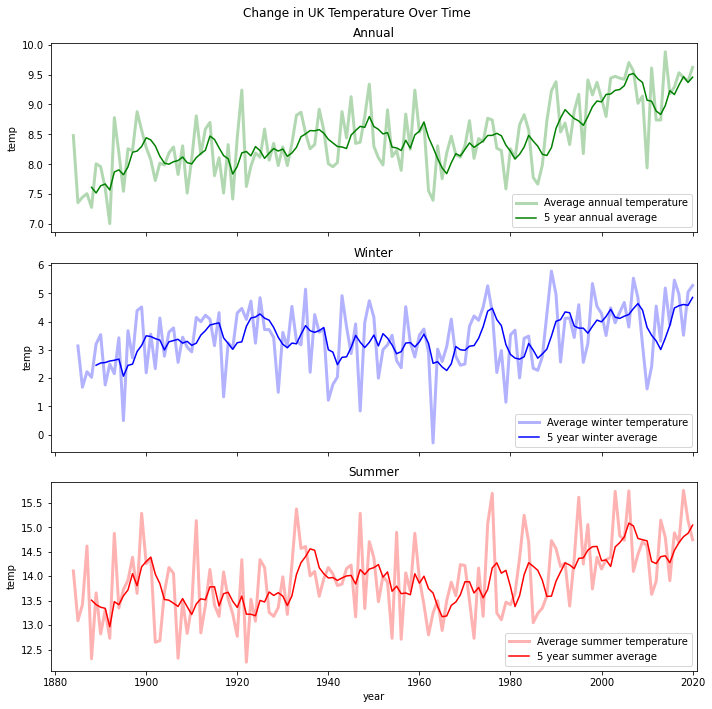

In [4]:
fig, axs = plt.subplots(3,1,figsize=(10,10),sharex=True)

axs[0].plot('year', 'ann', data=df, lw=3, color='green', alpha=0.3, label='Average annual temperature')
axs[0].plot('year', '5_year_average', lw=1.5, data=df, color='green', label='5 year annual average')
axs[0].legend(loc='lower right')

axs[1].plot('year', 'win', data=df, lw=3, color='blue', alpha=0.3, label='Average winter temperature')
axs[1].plot('year', '5_year_winter', data=df, lw=1.5, color='blue', label='5 year winter average')
axs[1].legend(loc='lower right')

axs[2].plot('year', 'sum', data=df, lw=3, color='red', alpha=0.3, label='Average summer temperature')
axs[2].plot('year', '5_year_summer', data=df, lw=1.5, color='red', label='5 year summer average')
axs[2].legend(loc='lower right')

axs[2].set_xlim(1879, 2021)
axs[2].set_xticks(range(1880, 2021, 20))
axs[2].set_xlabel('year')

axs[0].set_title('Annual')
axs[1].set_title('Winter')
axs[2].set_title('Summer')

axs[0].set_ylabel('temp')
axs[1].set_ylabel('temp')
axs[2].set_ylabel('temp')

fig.suptitle('Change in UK Temperature Over Time')

plt.tight_layout()


### Part b solution
First gather together the relevant data.
Using an inner join only keeps the years which have entries in both DataFrames. 

In [5]:
df_temp = pd.read_csv('annual_temperatures.csv')
df_sun = pd.read_csv('annual_sunshine_hours.csv')

df_temp.rename(columns={'may': 'may_temp'}, inplace=True)
df_sun.rename(columns={'may': 'may_sun'}, inplace=True)

df_comb = pd.merge(df_temp[['year','may_temp']], df_sun[['year','may_sun']], on='year', how='inner')

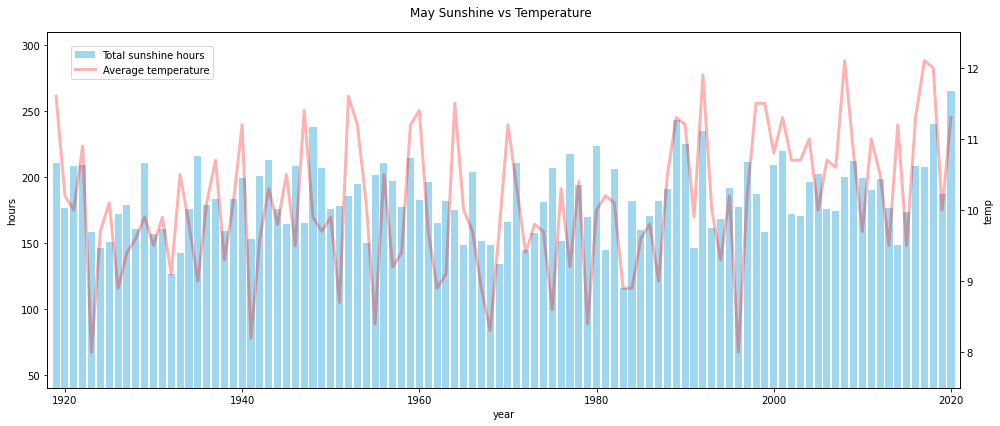

In [6]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

ax.bar('year', 'may_sun', data=df_comb, label='Total sunshine hours', color='skyblue', alpha=0.8)

ax2 = ax.twinx() # create a second Axes sharing the x axis of ax
ax2.plot('year', 'may_temp', data=df_comb, label='Average temperature', color='red', alpha=0.3, lw=3)

ax.set_xlim(1918, 2021)

# set the limits of each y axis so that the bars and line are roughly aligned
ax.set_ylim(40, 310)
ax2.set_ylim(7.5, 12.5)

ax.set_yticks(range(50, 310, 50))

# add titles and labels
fig.suptitle('May Sunshine vs Temperature')
fig.legend(bbox_to_anchor=[0.22,0.9]) # fine control over placement of figure legend
ax.set_ylabel('hours')
ax2.set_ylabel('temp')
ax.set_xlabel('year')

fig.tight_layout()

## Exercise 2 solution
Read in the two files and merge them.

In [7]:
df = pd.read_csv('life_expectancy_gdp_2011.csv')
df_countries = pd.read_csv('Continents.csv')
df_countries.rename(columns={'code_3':'Code'}, inplace=True)

df_comb = pd.merge(df, df_countries[['Code', 'country', 'continent']], on='Code', how='inner')

# to help plot sizes proportional to population
df_comb['Population millions'] = df_comb['Population']/1000000

df_comb.head()

,Entity,Code,Year,Population,Life expectancy,GDP per capita in 2011US$,country,continent,Population millions
0,Afghanistan,AFG,2011,30117000.0,61.553,1792.0,Afghanistan,Asia,30.117
1,Albania,ALB,2011,2929000.0,76.914,9484.0,Albania,Europe,2.929
2,Algeria,DZA,2011,36661000.0,75.199,13204.0,Algeria,Africa,36.661
3,Angola,AGO,2011,24221000.0,56.330,8016.0,Angola,Africa,24.221
4,Argentina,ARG,2011,41320000.0,75.439,20003.0,Argentina,Americas,41.320


We need to select colors depending on the continent.
The scatter method color parameter accepts a list of colors or a list of numbers.

In [8]:
# check what values exist for continent
df_comb['continent'].unique()

array(['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], dtype=object)

In [9]:
color_dict = {'Africa':1, 'Americas':2, 'Asia':3, 'Europe':4, 'Oceania':5}

df_comb['color'] = pd.NA # default value
for l, data in df_comb.iterrows():
    df_comb.loc[l,'color'] = color_dict[data['continent']]
    
df_comb.head()

,Entity,Code,Year,Population,Life expectancy,GDP per capita in 2011US$,country,continent,Population millions,color
0,Afghanistan,AFG,2011,30117000.0,61.553,1792.0,Afghanistan,Asia,30.117,3
1,Albania,ALB,2011,2929000.0,76.914,9484.0,Albania,Europe,2.929,4
2,Algeria,DZA,2011,36661000.0,75.199,13204.0,Algeria,Africa,36.661,1
3,Angola,AGO,2011,24221000.0,56.330,8016.0,Angola,Africa,24.221,1
4,Argentina,ARG,2011,41320000.0,75.439,20003.0,Argentina,Americas,41.320,2


Manual check that the merge has worked - check for entries where country names from the different DataFrames do not match. 

In [10]:
df_comb[df_comb['country']!= df_comb['Entity']]

,Entity,Code,Year,Population,Life expectancy,GDP per capita in 2011US$,country,continent,Population millions,color
15,Bolivia,BOL,2011,10213000.0,68.521,5331.0,Bolivia (Plurinational State of),Americas,10.213000,2
25,Cape Verde,CPV,2011,499000.0,71.243,6295.0,Cabo Verde,Africa,0.499000,1
38,Czechia,CZE,2011,10567000.0,77.843,26725.0,Czech Republic,Europe,10.567000,4
39,Democratic Republic of Congo,COD,2011,66755000.0,57.427,681.0,Congo (Democratic Republic of the),Africa,66.755000,1
49,Eswatini,SWZ,2011,1072000.0,48.141,7389.0,Swaziland,Africa,1.072000,1
69,Iran,IRN,2011,74635000.0,74.352,18024.0,Iran (Islamic Republic of),Asia,74.635000,3
81,Laos,LAO,2011,6348000.0,64.797,4401.0,Lao People's Democratic Republic,Asia,6.348000,3
97,Moldova,MDA,2011,4079000.0,70.119,4892.0,Moldova (Republic of),Europe,4.079000,4
110,North Korea,PRK,2011,24673000.0,70.012,1718.0,Korea (Democratic People's Republic of),Asia,24.673000,3
111,North Macedonia,MKD,2011,2072000.0,74.846,11321.0,Macedonia (the former Yugoslav Republic of),Europe,2.072000,4


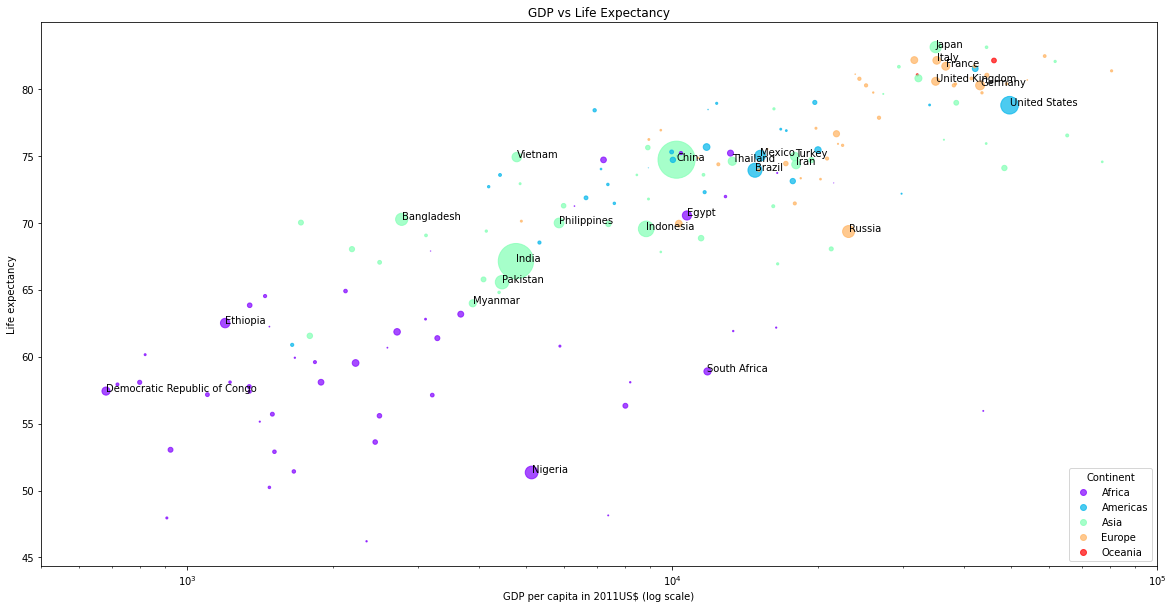

In [11]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_xlim(500, 100000)
ax.set_xscale('log')
ax.set_xlabel('GDP per capita in 2011US$ (log scale)')
ax.set_ylabel('Life expectancy')
ax.set_title('GDP vs Life Expectancy')

scatter_plot = ax.scatter(
    'GDP per capita in 2011US$', 
    'Life expectancy', 
    data = df_comb, 
    s='Population millions',
    c='color',
    alpha=0.7,
    cmap='rainbow'
)

# legend - get handles for each of the different colored data points
handles, labels = scatter_plot.legend_elements(prop='colors')
# add the legend using the dictionary keys as the labels
ax.legend(handles, color_dict.keys(), loc='lower right', title='Continent')

# add annotations for larger countries.
for l, data in df_comb.iterrows():
    if data['Population'] > 50000000:
        ax.annotate(
            data['Entity'], 
            (data['GDP per capita in 2011US$'], data['Life expectancy'])
        )

### Exercise 2: Alternative solution
This method has a different way of managing the colors which leads to a different method for creating the legend. 

In [12]:
df = pd.read_csv('life_expectancy_gdp_2011.csv')
df_countries = pd.read_csv('Continents.csv')
df_countries.rename(columns={'code_3':'Code'}, inplace=True)

df_comb = pd.merge(df, df_countries[['Code', 'country', 'continent']], on='Code', how='inner')

df_comb['Population millions'] = df_comb['Population']/1000000

# directly specify a color for each continent
color_dict = {'Africa':'purple', 'Americas':'orange', 'Asia':'green', 'Europe':'blue', 'Oceania':'red'}

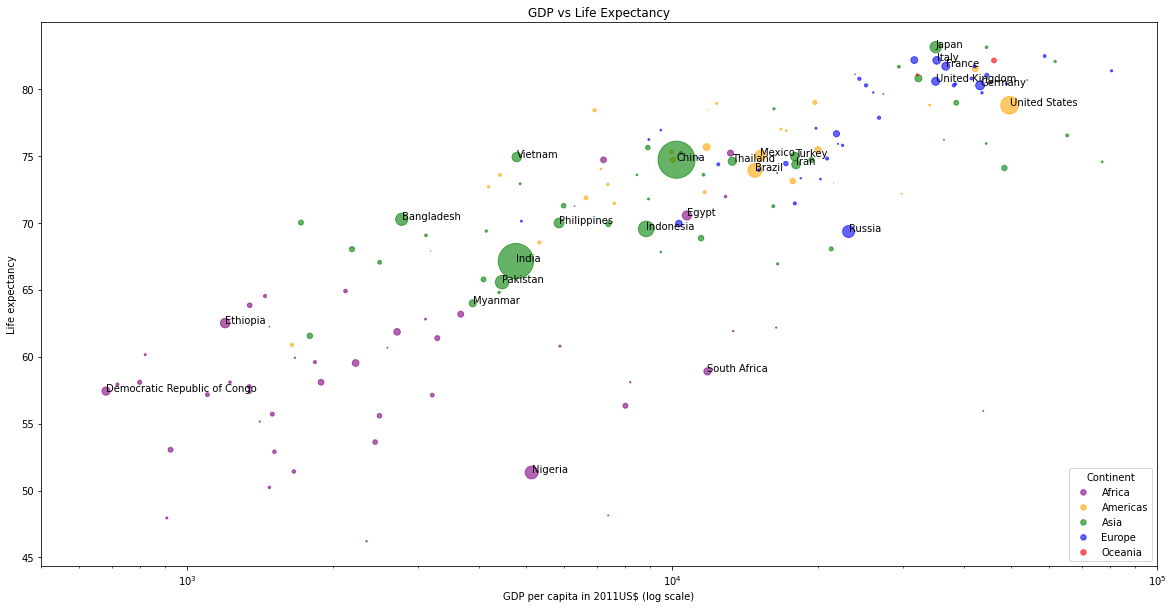

In [13]:
fig, ax = plt.subplots(figsize=(20,10))

ax.set_xlim(500, 100000)
ax.set_xscale('log')
ax.set_xlabel('GDP per capita in 2011US$ (log scale)')
ax.set_ylabel('Life expectancy')
ax.set_title('GDP vs Life Expectancy')

# plot each continent separately
for cont, col in color_dict.items():
    num = len(df_comb[df_comb['continent']==cont]) # number of data items
    colors = [col]*num # list of the chosen color, length equal to number of data items
    
    ax.scatter(
        'GDP per capita in 2011US$', 
        'Life expectancy', 
        data = df_comb[df_comb['continent']==cont], 
        s='Population millions',
        label=cont,
        c=colors,
        alpha=0.6
    )

# create the legend
leg = ax.legend(title='Continent',loc='lower right') 

# this is needed so that the icons in the legend all have the same size
# discussion at https://stackoverflow.com/questions/24706125/setting-a-fixed-size-for-points-in-legend
for handle in leg.legend_handles:
    handle.set_sizes([30])

# annotations
for l, data in df_comb.iterrows():
    if data['Population'] > 50000000:
        ax.annotate(
            data['Entity'], 
            (data['GDP per capita in 2011US$'], data['Life expectancy'])
        )